<a href="https://colab.research.google.com/github/kevinyang1704/ExData_Plotting1/blob/master/Copy_of_07_01_create_dataset_for_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create a Dataset for Sentiment Analysis

> TL;DR In this tutorial, you'll learn how to create a dataset for Sentiment Analysis by scraping user reviews for Android apps. You'll convert the app and review information into Data Frames and save that to CSV files.

- [Read the tutorial](https://www.curiousily.com/posts/create-dataset-for-sentiment-analysis-by-scraping-google-play-app-reviews-using-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1GDJIpz7BXw55jl9wTOMQDool9m8DIOyp)
- [Read the `Getting Things Done with Pytorch` book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You'll learn how to:

- Set a goal and inclusion criteria for your dataset
- Get real-world user reviews by scraping Google Play
- Use Pandas to convert and save the dataset into CSV files

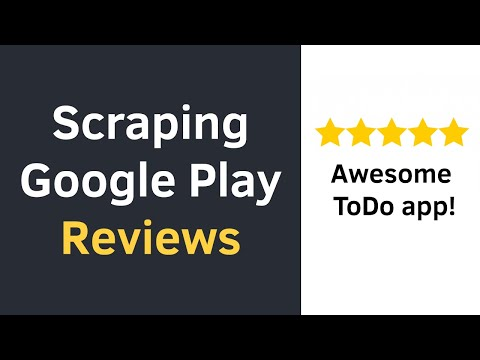

In [ ]:
#@title Watch the video tutorial

from IPython.display import YouTubeVideo
YouTubeVideo('-CAC4wK9Ey0', width=720, height=420)

## Setup

Let's install the required packages and setup the imports:

In [1]:
!pip install -qq google-play-scraper

     |████████████████████████████████| 51kB 1.6MB/s 


In [2]:
!pip install -qq -U watermark

In [3]:
%reload_ext watermark
%watermark -v -p pandas,matplotlib,seaborn,google_play_scraper

CPython 3.6.9
IPython 5.5.0

pandas 1.0.5
matplotlib 3.2.2
seaborn 0.10.1
google_play_scraper 0.0.3.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

## The Goal of the Dataset

You want to get feedback for your app. Both negative and positive are good. But the negative one can reveal critical features that are missing or downtime of your service (when it is much more frequent).

Lucky for us, Google Play has plenty of apps, reviews, and scores. We can scrape app info and reviews using the [google-play-scraper](https://github.com/JoMingyu/google-play-scraper) package.

You can choose plenty of apps to analyze. But different app categories contain different audiences, domain-specific quirks, and more. We'll start simple.

We want apps that have been around some time, so opinion is collected organically. We want to mitigate advertising strategies as much as possible. Apps are constantly being updated, so the time of the review is an important factor.

Ideally, you would want to collect every possible review and work with that. However, in the real world data is often limited (too large, inaccessible, etc). So, we'll do the best we can.

Let's choose some apps that fit the criteria from the *Productivity* category. We'll use [AppAnnie](https://www.appannie.com/apps/google-play/top-chart/?country=US&category=29&device=&date=2020-04-05&feed=All&rank_sorting_type=rank&page_number=1&page_size=100&table_selections=) to select some of the top US apps:

In [5]:
app_packages = [
  'com.chase.sig.android',
  'com.microsoft.todos'
]

## Scraping App Information

Let's scrape the info for each app:

In [6]:
app_infos = []

for ap in tqdm(app_packages):
  info = app(ap, lang='en', country='us')
  del info['comments']
  app_infos.append(info)

100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


We got the info for all 15 apps. Let's write a helper function that prints JSON objects a bit better:

In [7]:
def print_json(json_object):
  json_str = json.dumps(
    json_object, 
    indent=2, 
    sort_keys=True, 
    default=str
  )
  print(highlight(json_str, JsonLexer(), TerminalFormatter()))

Here is a sample app information from the list:

In [8]:
print_json(app_infos[0])

{
  "adSupported": null,
  "androidVersion": "6.0",
  "androidVersionText": "6.0 and up",
  "appId": "com.chase.sig.android",
  "containsAds": null,
  "contentRating": "Everyone",
  "contentRatingDescription": null,
  "currency": "USD",
  "description": "Bank from almost anywhere with the Chase Mobile\u00ae app. Manage your accounts, pay bills, pay people, deposit checks, even transfer money. And do it all safely and securely with your device.\r\n \r\nManage Your Accounts\r\n\r\n[+] View your account balance at Sign in using Account Preview.\r\n[+] Monitor your checking, savings, credit card or J.P. Morgan investment\u00a0activities.\r\n[+] Set up travel notifications for your debit and credit cards.\r\n[+] Set up Account Alerts and adjust your preferences.\r\n[+] Use Chase QuickDeposit\u00ae to deposit a check just by taking a photo.\r\n[+] Check and get updates on your credit score.\r\n[+] Access your personal Chase Home Lending dashboard for ways to make the most of homeownership.\r

This contains lots of information including the number of ratings, number of reviews and number of ratings for each score (1 to 5). Let's ignore all of that and have a look at their beautiful icons:

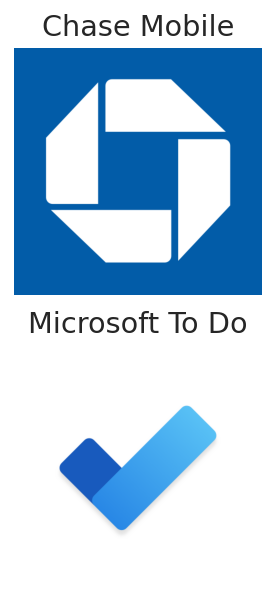

In [9]:
def format_title(title):
  sep_index = title.find(':') if title.find(':') != -1 else title.find('-')
  if sep_index != -1:
    title = title[:sep_index]
  return title[:15]

fig, axs = plt.subplots(2, len(app_infos) // 2, figsize=(14, 5))

for i, ax in enumerate(axs.flat):
  ai = app_infos[i]
  img = plt.imread(ai['icon'])
  ax.imshow(img)
  ax.set_title(format_title(ai['title']))
  ax.axis('off')

We'll store the app information for later by converting the JSON objects into a Pandas dataframe and saving the result into a CSV file:

In [10]:
app_infos_df = pd.DataFrame(app_infos)
app_infos_df.to_csv('apps.csv', index=None, header=True)

## Scraping App Reviews

In an ideal world, we would get all the reviews. But there are lots of them and we're scraping the data. That wouldn't be very polite. What should we do?

We want:

- Balanced dataset - roughly the same number of reviews for each score (1-5)
- A representative sample of the reviews for each app

We can satisfy the first requirement by using the scraping package option to filter the review score. For the second, we'll sort the reviews by their helpfulness, which are the reviews that Google Play thinks are most important. Just in case, we'll get a subset from the newest, too:

In [11]:
app_reviews = []

for ap in tqdm(app_packages):
  for score in list(range(1, 6)):
    for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
      rvs, _ = reviews(
        ap,
        lang='en',
        country='us',
        sort=sort_order,
        count= 200 if score == 3 else 100,
        filter_score_with=score
      )
      for r in rvs:
        r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
        r['appId'] = ap
      app_reviews.extend(rvs)

100%|██████████| 2/2 [00:06<00:00,  3.42s/it]


Note that we're adding the app id and sort order to each review. Here's an example for one:

In [12]:
print_json(app_reviews[0])

{
  "appId": "com.chase.sig.android",
  "at": "2020-07-17 21:05:14",
  "content": "The new update is the worst.\ud83d\ude21 First I had the challenge of trying to pay for my credit card bill, couldn't tap on \"other amount\" or any of the other payment amount options, I couldn't tap on my full statement/purchases for this month, and speaking to a customer service representative, he suggested I uninstall and reinstall the app only to be stuck on the user agreement and can't scroll or tap accept. Still on the phone, nothing's working. Very upsetting.",
  "repliedAt": null,
  "replyContent": null,
  "reviewCreatedVersion": "4.130",
  "reviewId": "gp:AOqpTOHgznZ_KWq4ueFPHQh3mT8DI0Xqv27HhyTvNnJ2JPwK_RZmHiosvjwz-qsOEpMBX1KVrKedt6N80tQKsfc",
  "score": 1,
  "sortOrder": "most_relevant",
  "thumbsUpCount": 34,
  "userImage": "https://lh3.googleusercontent.com/a-/AOh14GizWGxvW0sK02sUPryRQMasROmE3Vt2GXbZZu9hlw",
  "userName": "Jennyflorr"
}



`repliedAt` and `replyContent` contain the developer response to the review. Of course, they can be missing.

How many app reviews did we get?



In [13]:
len(app_reviews)

2400

Let's save the reviews to a CSV file:

In [14]:
app_reviews_df = pd.DataFrame(app_reviews)
app_reviews_df.to_csv('reviews.csv', index=None, header=True)

In [16]:
app_reviews_df.head(5)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOHgznZ_KWq4ueFPHQh3mT8DI0Xqv27HhyTvNnJ...,Jennyflorr,https://lh3.googleusercontent.com/a-/AOh14GizW...,The new update is the worst.😡 First I had the ...,1,34,4.130,2020-07-17 21:05:14,None,NaT,most_relevant,com.chase.sig.android
1,gp:AOqpTOFnbtRCA4qYTL5KLj4DMzuRECyz--AAZ3ufLnw...,Thoko 420,https://lh3.googleusercontent.com/-V2f0KJ7-8c0...,"Ever since the last update, I have to keep uni...",1,129,4.130,2020-07-15 17:04:02,None,NaT,most_relevant,com.chase.sig.android
2,gp:AOqpTOHtQegpUqnxB4OY44CFy8ERNuVZ0280iXqoF8w...,Michael Ku,https://lh3.googleusercontent.com/a-/AOh14Gi7p...,App works decently well but there are a ton of...,1,59,4.130,2020-07-08 14:30:43,None,NaT,most_relevant,com.chase.sig.android
3,gp:AOqpTOFvMj3z_1eNynOocLHnq1XwY6cRqo5zJwWGpLC...,Mrs Oneida A Cox,https://lh3.googleusercontent.com/a-/AOh14GiEO...,The new look not user friendly! Not sure what ...,1,6,4.130,2020-07-16 22:51:08,None,NaT,most_relevant,com.chase.sig.android
4,gp:AOqpTOGVumw_wXxJjdYJDHMma6nnrTliYpDhgTo2C9B...,R Gifford,https://lh3.googleusercontent.com/-sbVWS0g6ZHY...,Quit making me update the app constantly in or...,1,5,4.130,2020-07-16 21:32:02,None,NaT,most_relevant,com.chase.sig.android


## Summary

Well done! You now have a dataset with more than 15k user reviews from 15 productivity apps. Of course, you can go crazy and get much much more.

- [Read the tutorial](https://www.curiousily.com/posts/create-dataset-for-sentiment-analysis-by-scraping-google-play-app-reviews-using-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1GDJIpz7BXw55jl9wTOMQDool9m8DIOyp)
- [Read the `Getting Things Done with Pytorch` book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You learned how to:

- Set goals and expectations for your dataset
- Scrape Google Play app information
- Scrape user reviews for Google Play apps
- Save the dataset to CSV files

Next, we're going to use the reviews for sentiment analysis with BERT. But first, we'll have to do some text preprocessing!


## References

- [Google Play Scraper for Python](https://github.com/JoMingyu/google-play-scraper)